In [76]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.utils.data as Data
from torchvision import transforms
from torchvision.datasets import FashionMNIST


In [77]:
##使用FashionMNIST数据，准备训练数据集
train_data = FashionMNIST(
    root="./data/FashionMNIST",  ##数据的路径
    train=True,  ##只使用训练数据集
    transform=transforms.ToTensor(),
    download=True
)
##定义一个数据加载器
train_loader = Data.DataLoader(
    dataset=train_data,  ##使用数据集
    batch_size=64,  ##批处理样本大小
    shuffle=False,  ##每次迭代前不打乱数据
    num_workers=2,  ##使用两个进程
)
##计算train_loader有多少个batch
print("train_loader的batch数量为:", len(train_loader))

train_loader的batch数量为: 938


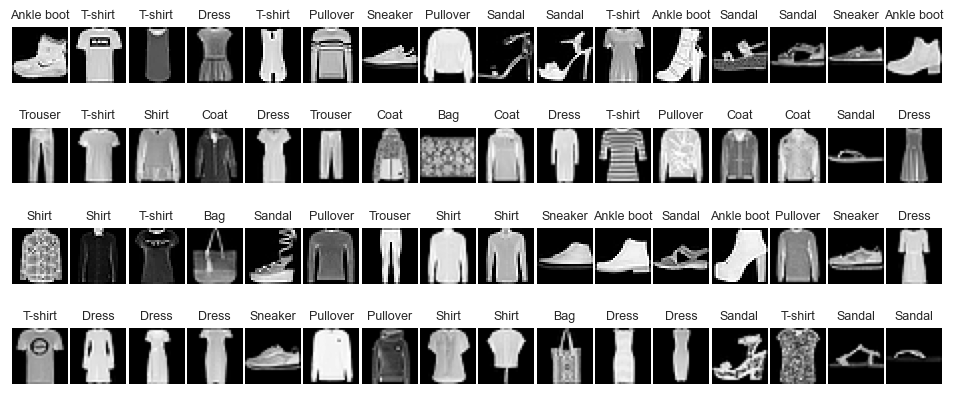

In [78]:
##获得一个batch的数据
for step, (b_x, b_y) in enumerate(train_loader):
    if step > 0:
        break
    ##可视化一个batch的图像
    batch_x = b_x.squeeze().numpy()
    batch_y = b_y.numpy()
    class_label = train_data.classes
    class_label[0] = "T-shirt"
    plt.figure(figsize=(12, 5))
    for ii in np.arange(len(batch_y)):
        plt.subplot(4, 16, ii + 1)
        plt.imshow(batch_x[ii, :, :], cmap=plt.cm.gray)
        plt.title(class_label[batch_y[ii]], size=9)
        plt.axis("off")
        plt.subplots_adjust(wspace=0.05)

In [79]:
##对测试集进行处理
test_data = FashionMNIST(
    root="./data/FashionMNIST",  ##数据路径
    train=False,  ##不使用训练数据集
    download=False  ##因为数据已经下载过，所以这里不在下载
)
##为数据添加一个维度，并且取值范围缩放到0~1之间
test_data_x = test_data.data.type(torch.FloatTensor) / 255.0
test_data_x = torch.unsqueeze(test_data_x, dim=1)
test_data_y = test_data.targets  ##测试集标签
print("test_data_x.shape:", test_data_x.shape)
print("test_data_y.shape:", test_data_y.shape)

test_data_x.shape: torch.Size([10000, 1, 28, 28])
test_data_y.shape: torch.Size([10000])


In [80]:
class MyconvNet(nn.Module):
    def __init__(self):
        super(MyconvNet, self).__init__()
        ##定义第一个 卷积层
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.AvgPool2d(
                kernel_size=2, stride=2,
            )
        )
        ##定义第二个卷积层
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 6 * 6, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        ## 定义前向传播路径

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  ##展平多维卷积图层
        output = self.classifier(x)
        return output


##输出我们的网络结构
myconvnet = MyconvNet()
print(myconvnet)

MyconvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [81]:
##定义网络的训练过程函数
def train_model(model, traindataloader, train_rate, criterion, optimizer, num_epochs=25):
    """

    :param model: 网络模型
    :param traindataloader: 训练数据集，会切分为训练集和数据集
    :param train_rate:训练集batchsize百分比
    :param criterion: 损失函数
    :param optimizer: 优化方法
    :param num_epochs: 训练轮数
    :return:
    """
    ##计算训练使用的batch数量
    batch_num = len(traindataloader)
    train_batch_num = round(batch_num * train_rate)
    ##复制模型的参数
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    since = time.time()
    for epoch in range(num_epochs):
        print('Epoch{}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        ##每个epoch有两个训练阶段
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        val_loss = 0.0
        val_corrects = 0
        val_num = 0
        for step, (b_x, b_y) in enumerate(traindataloader):
            if step < train_batch_num:
                model.train()  ##设置模型为训练模式
                output = model(b_x)
                pre_lab = torch.argmax(output, 1)
                loss = criterion(output, b_y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * b_x.size(0)
                train_corrects += torch.sum(pre_lab == b_y.data)
                train_num += b_x.size(0)
                print("train*****{}",train_num)
            else:
                model.eval()  ##设置模型为评估模式
                output=model(b_x)
                pre_lab=torch.argmax(output,1)
                loss=criterion(output,b_y)
                val_loss+=loss.item()*b_x.size(0)
                val_corrects+=torch.sum(pre_lab==b_y.data)
                val_num+=b_x.size(0)
                print("val*****{}",val_num)

        ##计算一个epoch在训练集和验证集上的损失和精度
        print(train_num)
        train_loss_all.append(train_loss/train_num)
        print(train_corrects)
        train_acc_all.append(train_corrects.double().item()/train_num)
        val_loss_all.append(val_loss/val_num)
        print(val_corrects)
        val_acc_all.append(val_corrects.double().item()/val_num)
        print('{} Train Loss: {:.4f} Train Acc:{:.4f}'.format(epoch,train_loss_all[-1],train_acc_all[-1]))
        print('{} Val Loss: {:.4f} Val Acc:{:.4f}'.format(epoch,val_loss_all[-1],val_acc_all[-1]))
        ##拷贝模型最高精度下的参数
        if val_acc_all[-1]>best_acc:
            best_acc=val_acc_all[-1]
            best_model_wts=copy.deepcopy(model.state_dict())
        time_use=time.time()-since
        print("Train and val complete in {:.0f}m {:.0f}s".format(time_use//60,time_use%60))
    ##使用最好模型的参数
    model.load_state_dict(best_model_wts)
    train_process=pd.DataFrame(
        data={
            "epoch":range(num_epochs),
            "train_loss_all":train_loss_all,
            "val_loss_all":val_loss_all,
            "train_acc_all":train_acc_all,
            "val_acc_all":val_acc_all
        }
    )
    return model,train_process

In [82]:
##对模型进行训练
optimizer=torch.optim.Adam(myconvnet.parameters(),lr=0.0003)
criterion=nn.CrossEntropyLoss()##损失函数
myconvnet,train_process=train_model(
    myconvnet,train_loader,0.8,criterion,optimizer,num_epochs=25
)

Epoch0/24
----------
train*****{} 64
train*****{} 128
train*****{} 192
train*****{} 256
train*****{} 320
train*****{} 384
train*****{} 448
train*****{} 512
train*****{} 576
train*****{} 640
train*****{} 704
train*****{} 768
train*****{} 832
train*****{} 896
train*****{} 960
train*****{} 1024
train*****{} 1088
train*****{} 1152
train*****{} 1216
train*****{} 1280
train*****{} 1344
train*****{} 1408
train*****{} 1472
train*****{} 1536
train*****{} 1600
train*****{} 1664
train*****{} 1728
train*****{} 1792
train*****{} 1856
train*****{} 1920
train*****{} 1984
train*****{} 2048
train*****{} 2112
train*****{} 2176
train*****{} 2240
train*****{} 2304
train*****{} 2368
train*****{} 2432
train*****{} 2496
train*****{} 2560
train*****{} 2624
train*****{} 2688
train*****{} 2752
train*****{} 2816
train*****{} 2880
train*****{} 2944
train*****{} 3008
train*****{} 3072
train*****{} 3136
train*****{} 3200
train*****{} 3264
train*****{} 3328
train*****{} 3392
train*****{} 3456
train*****{} 3520
train

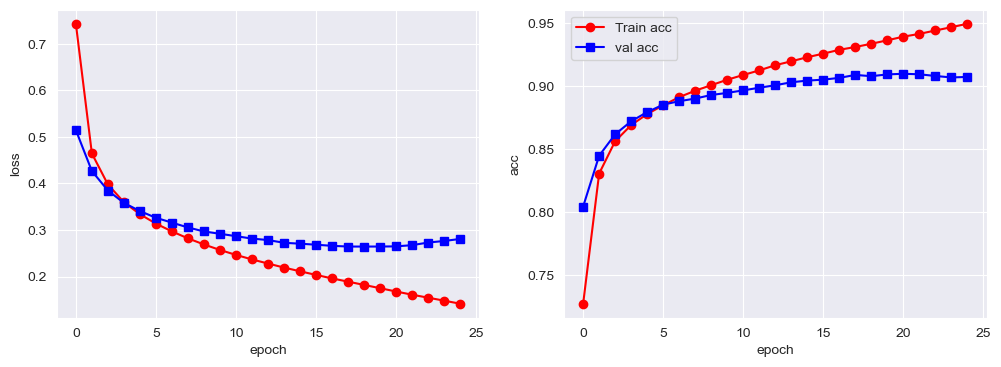

In [90]:
##可视化模型训练过程
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_process.epoch,train_process.train_loss_all,"ro-",label="Train loss")
plt.plot(train_process.epoch,train_process.val_loss_all,"bs-",label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.subplot(1,2,2)
plt.plot(train_process.epoch,train_process.train_acc_all,"ro-",label="Train acc")
plt.plot(train_process.epoch,train_process.val_acc_all,"bs-",label="val acc")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

In [89]:
##对测试集进行预测，并可视化预测效果
myconvnet.eval()
output=myconvnet(test_data_x)
pre_lab=torch.argmax(output,1)
acc=accuracy_score(test_data_y,pre_lab)
print("在测试集上的预测精度为：",acc)

在测试集上的预测精度为： 0.9007


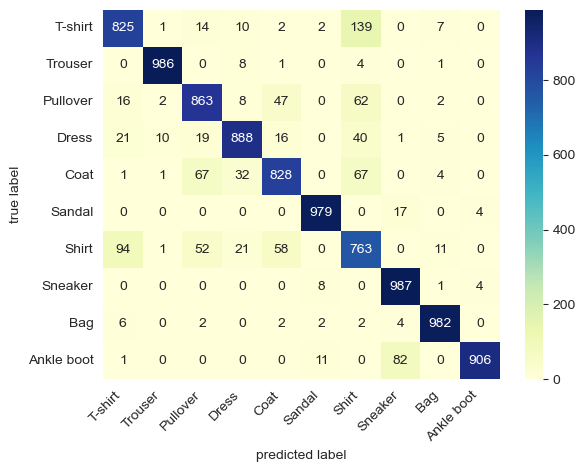

In [95]:
##计算混淆矩阵并可视化
conf_mat=confusion_matrix(test_data_y,pre_lab)
df_cm=pd.DataFrame(conf_mat,index=class_label,columns=class_label)
heatmap=sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),rotation=0,ha="right")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),rotation=45,ha="right")
plt.ylabel("true label")
plt.xlabel("predicted label")
plt.show()